# APS360 Project: Baseline

### Part A. Data Loading

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
from PIL import Image
import shutil
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.multiprocessing as mp
from tqdm import tqdm

mp.set_start_method('spawn', force=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 2
LEARNING_RATE = 0.0002
LAMBDA_IDENTITY = 0.0  # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 1
NUM_EPOCHS = 50
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_ANIME = "models/gen_anime"
CHECKPOINT_GENERATOR_HUMAN = "models/gen_human"
CHECKPOINT_DISCRIMINATOR_ANIME = "models/disc_anime"
CHECKPOINT_DISCRIMINATOR_HUMAN = "models/disc_human"

#### 0. Helper Functions

In [2]:
###############################################################################
# Data Loading
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler


class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Since there are no labels, we can return a dummy label (0)

def create_subset_dataset(original_dir, subset_dir, subset_size=100):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    image_paths = [os.path.join(original_dir, fname) for fname in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, fname))]
    
    np.random.seed(1000)
    np.random.shuffle(image_paths)
    subset_paths = image_paths[:subset_size]
    
    for img_path in subset_paths:
        shutil.copy(img_path, subset_dir)

    print(f"Subset created with {len(subset_paths)} images in {subset_dir}")

def get_data_loader(data_dir, batch_size, image_size=(224, 224), subset_size=None):

    transform = transforms.Compose([
        transforms.Resize(image_size),
        #transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    dataset = CustomImageDataset(root_dir=data_dir, transform=transform)

    if subset_size:
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)
        subset_indices = indices[:subset_size]
        subset_sampler = SubsetRandomSampler(subset_indices)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler)
        return loader

    def split_indices(dataset):
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)

        train_split = int(0.7 * num_images)
        val_split = int(0.15 * num_images)

        train_indices = indices[:train_split]
        val_indices = indices[train_split:train_split + val_split]
        test_indices = indices[train_split + val_split:]

        return train_indices, val_indices, test_indices

    train_indices, val_indices, test_indices = split_indices(dataset)

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader

def verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B):
    # Verify the split sizes for dataset A
    total_examples_A = len(train_loader_A.sampler) + len(val_loader_A.sampler) + len(test_loader_A.sampler)
    train_size_A = len(train_loader_A.sampler)
    val_size_A = len(val_loader_A.sampler)
    test_size_A = len(test_loader_A.sampler)

    train_proportion_A = train_size_A / total_examples_A
    val_proportion_A = val_size_A / total_examples_A 
    test_proportion_A = test_size_A / total_examples_A

    print(f"Dataset A - Total examples: {total_examples_A}")
    print(f"Dataset A - Train examples: {train_size_A} ({train_proportion_A:.2%})")
    print(f"Dataset A - Validation examples: {val_size_A} ({val_proportion_A:.2%})")
    print(f"Dataset A - Test examples: {test_size_A} ({test_proportion_A:.2%})")

    # Verify the split sizes for dataset B
    total_examples_B = len(train_loader_B.sampler) + len(val_loader_B.sampler) + len(test_loader_B.sampler)
    train_size_B = len(train_loader_B.sampler)
    val_size_B = len(val_loader_B.sampler)
    test_size_B = len(test_loader_B.sampler)

    train_proportion_B = train_size_B / total_examples_B
    val_proportion_B = val_size_B / total_examples_B 
    test_proportion_B = test_size_B / total_examples_B

    print(f"Dataset B - Total examples: {total_examples_B}")
    print(f"Dataset B - Train examples: {train_size_B} ({train_proportion_B:.2%})")
    print(f"Dataset B - Validation examples: {val_size_B} ({val_proportion_B:.2%})")
    print(f"Dataset B - Test examples: {test_size_B} ({test_proportion_B:.2%})")

    # Check for overlaps in dataset A
    train_indices_A = list(train_loader_A.sampler.indices)
    val_indices_A = list(val_loader_A.sampler.indices)
    test_indices_A = list(test_loader_A.sampler.indices)
    print("Checking overlaps for dataset A...")
    check_for_overlaps(train_indices_A, val_indices_A, test_indices_A)

    # Check for overlaps in dataset B
    train_indices_B = list(train_loader_B.sampler.indices)
    val_indices_B = list(val_loader_B.sampler.indices)
    test_indices_B = list(test_loader_B.sampler.indices)
    print("Checking overlaps for dataset B...")
    check_for_overlaps(train_indices_B, val_indices_B, test_indices_B)

def check_for_overlaps(train_indices, val_indices, test_indices):
    # Convert indices to sets
    train_indices_set = set(train_indices)
    val_indices_set = set(val_indices)
    test_indices_set = set(test_indices)

    # Check for overlaps
    train_val_overlap = train_indices_set.intersection(val_indices_set)
    train_test_overlap = train_indices_set.intersection(test_indices_set)
    val_test_overlap = val_indices_set.intersection(test_indices_set)

    # Print the results
    print(f"Train/Validation Overlap: {len(train_val_overlap)} indices")
    print(f"Train/Test Overlap: {len(train_test_overlap)} indices")
    print(f"Validation/Test Overlap: {len(val_test_overlap)} indices")

    if not train_val_overlap and not train_test_overlap and not val_test_overlap:
        print("No overlaps found between train, validation, and test sets.")
    else:
        print("Overlaps detected. Please check the data splitting logic.")

###############################################################################
# Training
import glob

def evaluate(generator, discriminator, loader, criterion, device):
    generator.eval()
    discriminator.eval()
    
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            
            # Generate fake images
            fake_images = generator(inputs)
            outputs = discriminator(fake_images)
            
            # Calculate loss
            loss = criterion(outputs, torch.ones_like(outputs).to(device))
            total_loss += loss.item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"=> Saving checkpoint to {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_latest_checkpoint(model, optimizer, checkpoint_prefix, lr, batch_size):
    checkpoint_files = glob.glob(f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_*.pth.tar")
    if not checkpoint_files:
        print(f"=> No checkpoint found for {checkpoint_prefix}. Starting from scratch.")
        return 0

    # Extract the latest epoch number from the checkpoint file names
    latest_epoch = max([int(file.split('_')[-1].split('.')[0]) for file in checkpoint_files])
    checkpoint_file = f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_{latest_epoch}.pth.tar"

    print(f"=> Loading checkpoint {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    return latest_epoch + 1

def get_model_name(model_type, epoch, learning_rate, batch_size):
    return f"models/{model_type}_lr{learning_rate}_bs{batch_size}_epoch_{epoch}.pth.tar"

def list_checkpoints(checkpoint_prefix):
    checkpoint_pattern = os.path.join(f"{checkpoint_prefix}_epoch_*.pth.tar")
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if not checkpoint_files:
        print(f"No checkpoint found for prefix: {checkpoint_prefix}")
    else:
        print(f"Checkpoints found for prefix {checkpoint_prefix}:")
        for checkpoint in checkpoint_files:
            print(checkpoint)
            
def save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, path_prefix):
    np.savetxt(f"{path_prefix}_train_loss_anime.csv", train_loss_anime_history)
    np.savetxt(f"{path_prefix}_train_loss_human.csv", train_loss_human_history)
    np.savetxt(f"{path_prefix}_val_loss_anime.csv", val_loss_anime_history)
    np.savetxt(f"{path_prefix}_val_loss_human.csv", val_loss_human_history)


###############################################################################
# Training Curve
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_loss_anime_file = f"{path}_train_loss_anime.csv"
    train_loss_human_file = f"{path}_train_loss_human.csv"
    val_loss_anime_file = f"{path}_val_loss_anime.csv"
    val_loss_human_file = f"{path}_val_loss_human.csv"

    train_loss_anime = np.loadtxt(train_loss_anime_file)
    train_loss_human = np.loadtxt(train_loss_human_file)
    val_loss_anime = np.loadtxt(val_loss_anime_file)
    val_loss_human = np.loadtxt(val_loss_human_file)

    plt.figure()
    plt.title("Train vs Validation Loss (Anime)")
    n = len(train_loss_anime)  # number of epochs
    plt.plot(range(1, n + 1), train_loss_anime, label="Train Anime")
    plt.plot(range(1, n + 1), val_loss_anime, label="Validation Anime")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss (Human)")
    plt.plot(range(1, n + 1), train_loss_human, label="Train Human")
    plt.plot(range(1, n + 1), val_loss_human, label="Validation Human")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    

### 1. Data Loading and Splitting

#### 1.1 Load Data

In [3]:
# Use smaller subsets for quick testing
create_subset_dataset('/root/aps360-project/data/dataSetA_10k', 'data/subset_dataSetA', subset_size=500)
create_subset_dataset('/root/aps360-project/data/dataSetB_10k', 'data/subset_dataSetB', subset_size=500)

# Load data from the subsets
train_loader_A, val_loader_A, test_loader_A = get_data_loader('/root/aps360-project/baseline/data/subset_dataSetA', BATCH_SIZE, image_size=(128, 128))
train_loader_B, val_loader_B, test_loader_B = get_data_loader('/root/aps360-project/baseline/data/subset_dataSetB', BATCH_SIZE, image_size=(128, 128))

Subset created with 500 images in data/subset_dataSetA
Subset created with 500 images in data/subset_dataSetB


In [4]:
# Load data from the full datasets
#train_loader_A, val_loader_A, test_loader_A = get_data_loader('/root/aps360-project/data/dataSetA_10k', BATCH_SIZE, image_size=(128, 128))
#train_loader_B, val_loader_B, test_loader_B = get_data_loader('/root/aps360-project/data/dataSetB_10k', BATCH_SIZE, image_size=(128, 128))

#### 1.2 Verify Split and Overlap

In [5]:
# Check for overlaps
verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B)

Dataset A - Total examples: 500
Dataset A - Train examples: 350 (70.00%)
Dataset A - Validation examples: 75 (15.00%)
Dataset A - Test examples: 75 (15.00%)
Dataset B - Total examples: 500
Dataset B - Train examples: 350 (70.00%)
Dataset B - Validation examples: 75 (15.00%)
Dataset B - Test examples: 75 (15.00%)
Checking overlaps for dataset A...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.
Checking overlaps for dataset B...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.


#### 1.3 Visualize Data

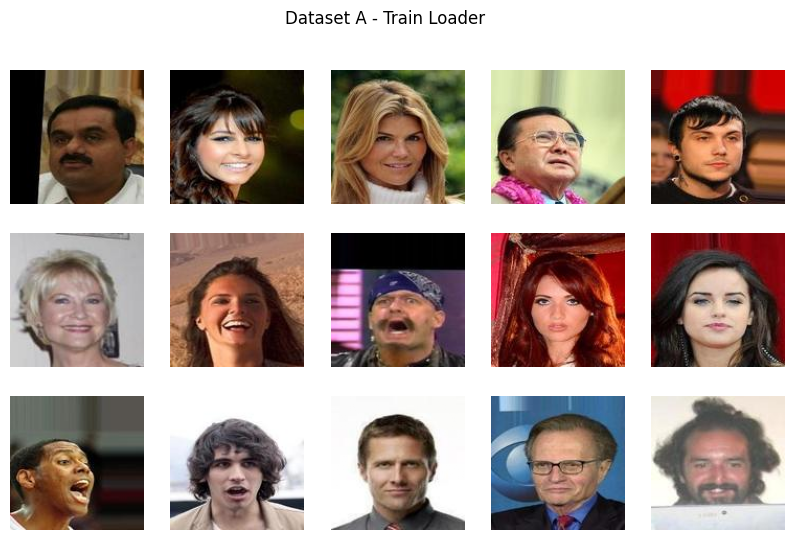

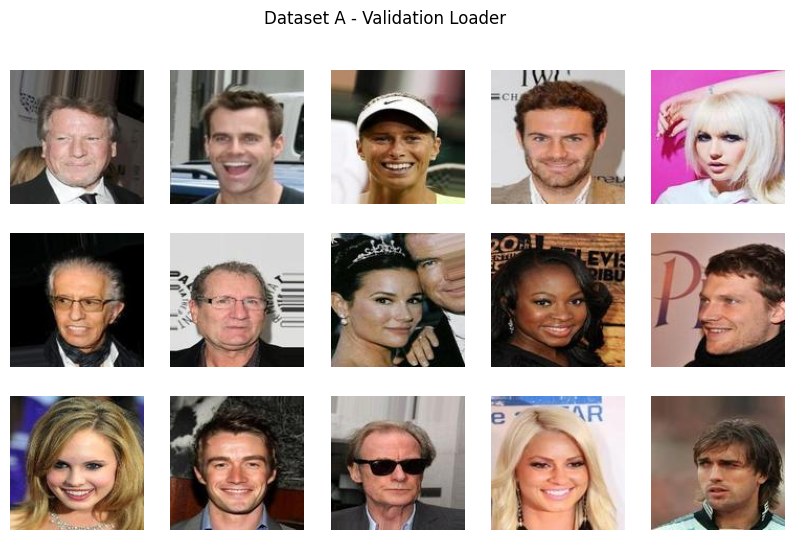

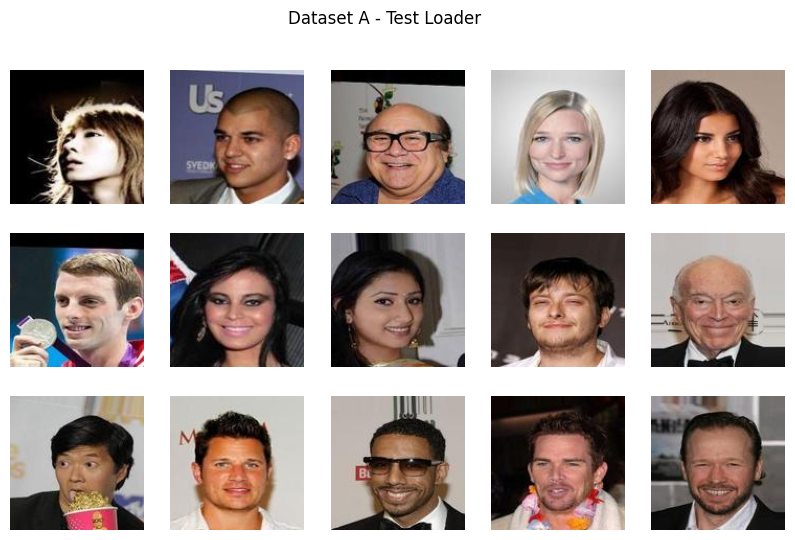

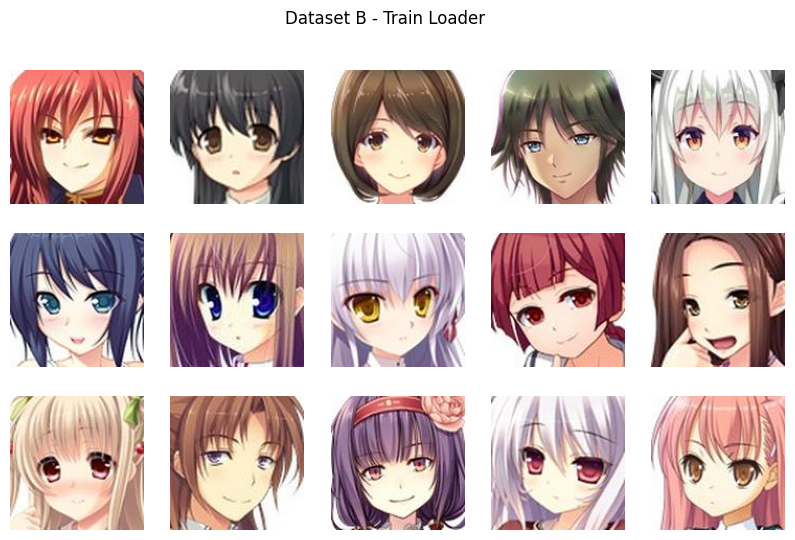

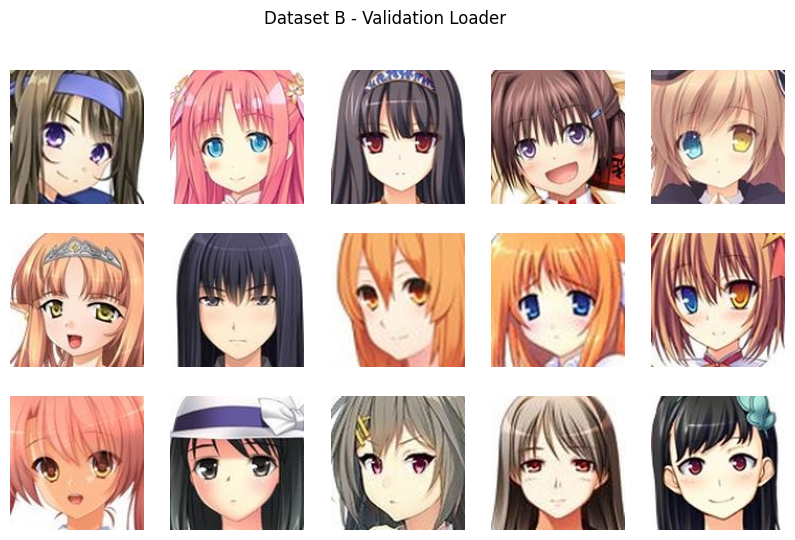

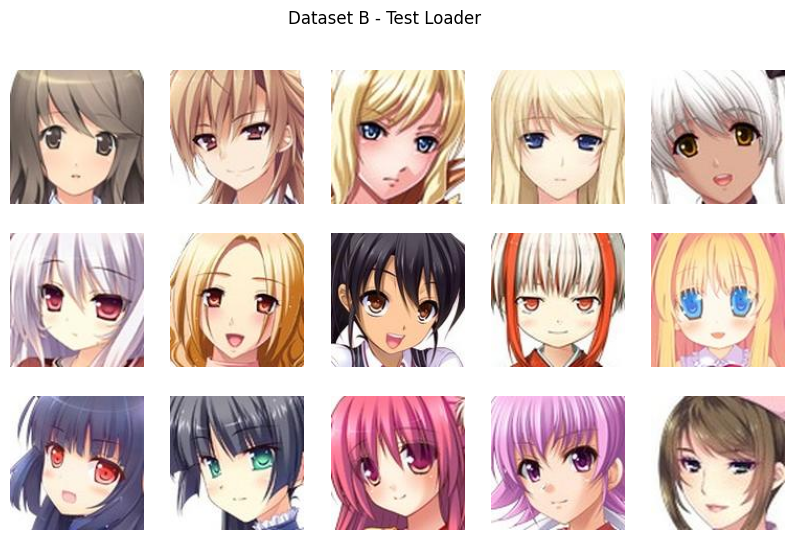

In [6]:
import matplotlib.pyplot as plt

# Taken from Lab 2
def visualize_data_loader(data_loader, title, num_images=15):
    k = 0
    plt.figure(figsize=(10, 6))
    for images, labels in data_loader:
        for i in range(images.size(0)):  
            if k >= num_images:
                break
            image = images[i]
            img = np.transpose(image.numpy(), [1, 2, 0])
            img = img / 2 + 0.5
            plt.subplot(3, 5, k+1)
            plt.axis('off')
            plt.imshow(img)
            k += 1
        if k >= num_images:
            break
    plt.suptitle(title)
    plt.show()

# Visualize dataset A
visualize_data_loader(train_loader_A, title="Dataset A - Train Loader")
visualize_data_loader(val_loader_A, title="Dataset A - Validation Loader")
visualize_data_loader(test_loader_A, title="Dataset A - Test Loader")

# Visualize dataset B
visualize_data_loader(train_loader_B, title="Dataset B - Train Loader")
visualize_data_loader(val_loader_B, title="Dataset B - Validation Loader")
visualize_data_loader(test_loader_B, title="Dataset B - Test Loader")

## 2. Model Building and Sanity Check

#### 2.1 Generator

In [7]:
class transconv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    super(transconv_block,self).__init__()
    self.transconv_block=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
  def forward(self,x):
    return self.transconv_block(x)

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super(conv_block, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.conv_block(x)

In [8]:
class Generator(nn.Module):
  def __init__(self):
      super(Generator, self).__init__()

      self.enc_layer1 = conv_block(9, 8)  # Modified input channel. Find root cause
      self.enc_layer2 = conv_block(8, 16)
      self.enc_layer3 = conv_block(16, 32)
      self.enc_layer4 = conv_block(32, 64)
      self.enc_layer5 = conv_block(64, 128)
      self.bottleneck = conv_block(128, 256, kernel_size=4, stride=1, padding=0)

      self.dec_layer1 = transconv_block(256, 128, kernel_size=4, stride=1, padding=0)
      self.dec_layer2 = transconv_block(256, 64)
      self.dec_layer3 = transconv_block(128, 32)
      self.dec_layer4 = transconv_block(64, 16)
      self.dec_layer5 = transconv_block(32, 8)
      self.dec_layer6 = transconv_block(16, 3)
      self.dec_layer7 = nn.ConvTranspose2d(6, 3, kernel_size=1, stride=1, padding=0)

  def forward(self, x, z):
      z = z.view(z.size(0), 3, 128, 128) #forced to adjust to 3 channels. Figure root cause
      x_noisy = torch.cat([z, x], 1)
      enc1 = self.enc_layer1(x_noisy)
      enc2 = self.enc_layer2(enc1)
      enc3 = self.enc_layer3(enc2)
      enc4 = self.enc_layer4(enc3)
      enc5 = self.enc_layer5(enc4)
      latent = self.bottleneck(enc5)
      dec1 = torch.cat([self.dec_layer1(latent), enc5], 1)
      dec2 = torch.cat([self.dec_layer2(dec1), enc4], 1)
      dec3 = torch.cat([self.dec_layer3(dec2), enc3], 1)
      dec4 = torch.cat([self.dec_layer4(dec3), enc2], 1)
      dec5 = torch.cat([self.dec_layer5(dec4), enc1], 1)
      dec6 = torch.cat([self.dec_layer6(dec5), x], 1)
      output = self.dec_layer7(dec6)

      return output

#### 2.2 Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            conv_block(6, 8),  # Adjust input channels to 6 (3 from real/fake_A + 3 from real_B)
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        concat = torch.cat([x, y], 1)  # Concatenate along the channel dimension
        out = self.model(concat)
        label = out.view(out.size(0), -1)
        return label  # real/fake

#### 2.3 Weight Initialization

In [10]:
#Clearing cache
import gc
torch.cuda.empty_cache()
gc.collect()

29489

## 3 Training Code

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE_GEN = 2e-5
LEARNING_RATE_DISC = 1e-4
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 32
FEATURES_GEN = 32

start_time = time.time()

torch.manual_seed(1000)

factor = 1

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.train()
discriminator.train()

opt_Gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE_GEN, betas=(0.5, 0.999))
opt_Disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_DISC, betas=(0.5, 0.999))

loss = nn.BCELoss()

writer_real_A = SummaryWriter(f"logs/real_A")
writer_fake_B = SummaryWriter(f"logs/fake_B")
writer_real_B = SummaryWriter(f"logs/real_B")
writer_fake_A = SummaryWriter(f"logs/fake_A")
step = 0


# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    epoch_loop = tqdm(zip(train_loader_A, train_loader_B), total=min(len(train_loader_A), len(train_loader_B)), leave=True, desc="Iteration")
    
    for batch_idx, ((real_A, _), (real_B, _)) in enumerate(epoch_loop):
        opt_Gen.zero_grad()
        opt_Disc.zero_grad()

        real_A = real_A.to(device)
        real_B = real_B.to(device)

        if batch_idx % factor == 0:
            ### Discriminator ###
            # For real data
            loss_real = loss(discriminator(real_A, real_B), torch.ones((real_A.size(0), 1), device=device) * 0.9)

            # For fake data
            z = torch.randn(real_A.size(0), 3, IMAGE_SIZE, IMAGE_SIZE).to(device)  # Adjust z shape to [batch_size, 3, 128, 128]
            loss_fake = loss(discriminator(real_A, generator(real_A, z).detach()), torch.ones((real_A.size(0), 1), device=device) * 0.1)

            loss_Disc_A = loss_real + loss_fake
            loss_Disc_A.backward()
            opt_Disc.step()

        ### Generator ###
        z = torch.rand(real_A.size(0), 3, IMAGE_SIZE, IMAGE_SIZE).to(device)  # Adjust z shape to [batch_size, 3, 128, 128]
        loss_Gen_A = loss(discriminator(real_A, generator(real_A, z)), torch.ones((real_A.size(0), 1), device=device))
        loss_Gen_A.backward()
        opt_Gen.step()

        # TensorBoard logging
        if batch_idx % 100 == 0:
            with torch.no_grad():
                img_grid_real_A = torchvision.utils.make_grid(real_A[:32], normalize=True)
                img_grid_fake_B = torchvision.utils.make_grid(generator(real_A, z)[:32], normalize=True)
                img_grid_real_B = torchvision.utils.make_grid(real_B[:32], normalize=True)
                img_grid_fake_A = torchvision.utils.make_grid(generator(real_B, z)[:32], normalize=True)

                writer_real_A.add_image("Real_A", img_grid_real_A, global_step=step)
                writer_fake_B.add_image("Fake_B", img_grid_fake_B, global_step=step)
                writer_real_B.add_image("Real_B", img_grid_real_B, global_step=step)
                writer_fake_A.add_image("Fake_A", img_grid_fake_A, global_step=step)
            step += 1
        
        torch.cuda.empty_cache()
        del real_A, real_B, z, loss_Disc_A, loss_Gen_A

print("Training Done")
end_time = time.time()
print(f"Time taken: {end_time - start_time}")

## Result